# Plots the Foreground and Background Spectra after Separating the Lens

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import fitsio
import matplotlib.pyplot as plt
import seaborn as sb

from astropy.table import Table

In [2]:
# Set some plotting environment variables
sb.set(style='white', context='poster', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

In [3]:
def readCoadd(coaddPath, fastmeta):
    '''
    Reads in the coadd path as a Spectra object then coadds it and performs dust correction

    coaddPath [Str] : path to the coadded, original spectrum
    '''
    
    from desispec.io import read_spectra
    from desispec.spectra import Spectra
    from desispec.coaddition import coadd_cameras
    from desiutil.dust import dust_transmission
    
    spec = read_spectra(coaddPath)
    # prep the coadded spectrum
    coaddSpec = coadd_cameras(spec)
    bands = coaddSpec.bands[0]
    
    # MW dust transmission correction
    mwSpec = dust_transmission(coaddSpec.wave[bands], fastmeta['EBV'])
    
    coaddSpec.flux = {'brz' : coaddSpec.flux[bands] / mwSpec}
    
    return coaddSpec

In [4]:
def getFastspecModel(fastfile):
    '''
    Reads in fastspec model and preps it for next steps
    
    fastfile [str] : path to fastspecfit output file
    '''
    
    import fitsio
    from astropy.table import Table
    
    # read in the metadata
    modelmeta = Table(fitsio.read(fastfile, 'METADATA'))
    
    # read in fastspecfit model
    models, hdr = fitsio.read(fastfile, 'MODELS', header=True)
    modelwave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1']) * hdr['CDELT1']
    
    modelflux = np.sum(models, axis=1).flatten()
    
    return modelwave, modelflux, modelmeta

In [5]:
def plotFastspecModel(fastWave, fastFlux, coaddSpec, ax=None):
    '''
    Function to plot the fastspecfit model over the original spectrum
    '''
    from desispec.io import read_spectra
    
    if not ax:
        fig, ax = plt.subplots(figsize=(20,6))
        
    # plot original coadded spectrum in the background
    for band in coaddSpec.bands:
        ax.plot(coaddSpec.wave[band], coaddSpec.flux[band][0], color='k', alpha=0.5)
    
    # plot fastspecfit model
    ax.plot(fastWave, fastFlux, 'r-', label='fastspecfit Model')
    
    ax.set_xlim([3500, 9900])
    ax.set_xlabel('$\lambda$ [$\AA$]')
    ax.set_ylabel('F$_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    ax.legend()

In [6]:
def plotDesiSpectra(coaddSpec, smooth=True, ax=None, emline=False, z=0, **kwargs):
    '''
    Plots desi spectra from a coadd file
    
    coaddSpec [Spectra] : desispec Spectra object to plot, must provide if coaddSpec isn't provided
    smooth [bool] : if set to True, overplot the smooth spectrum
    ax [Matplotlib Axes] : Matplotlib Axes object to plot on, optional, if not provided, a new one will be created
    emline [bool] : if set to True, overplot common strong emission lines
    z [float] : redshift of galaxy with the emission lines to overplot, default=0
    '''
    from astropy.convolution import convolve, Gaussian1DKernel
    
    if not ax:
        fig, ax = plt.subplots(figsize = (20, 6))
        
    colors = ['b', 'g', 'r']
    for band, color in zip(coaddSpec.bands, colors):
        # Plot the spectrum from each arm (B,R,Z) in blue, green, red
        ax.plot(coaddSpec.wave[band], coaddSpec.flux[band][0], color = color, alpha = 0.5)

        if smooth:    
            # Over-plotting smoothed spectra in black for all the three arms
            ax.plot(coaddSpec.wave[band], convolve(coaddSpec.flux[band][0], Gaussian1DKernel(5)), color = 'k')
        
        if emline:
            
            emlines = Table.read('emlines.ecsv', format='ascii.ecsv')
            emlines = emlines[emlines['amp'] >= 1]
            
            plotted = []
            for ii, row in enumerate(emlines):
                
                obsWave = (1+z) * row['restwave']
                
                if obsWave > min(coaddSpec.wave[band]) and obsWave < max(coaddSpec.wave[band]):
                    ax.axvline(obsWave, color='k', linestyle='--', alpha=0.4)
                    if row['nicename'] not in plotted:
                        ax.text(obsWave, min(coaddSpec.flux[band][0])/2, row['nicename'], rotation=270, fontsize=12, verticalalignment='center')
                        plotted.append(row['nicename'])
    
    ax.set_xlim([3500, 9900])
    ax.set_xlabel('$\lambda$ [$\AA$]')
    ax.set_ylabel('F$_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

In [7]:
def subtract_spectra(spec, frontFlux, frontWave, outdir=''):
    '''
    Subtract the foreground spectrum from the original coadded spectroscopic lens
    
    spec [DESI Spectra Object] : Spectra object with the original spectroscopic lens
    frontFlux [Array] : 1D array of the foreground object flux
    frontWave [Array] : 1D array of the foreground object wavelength
    outdir [str] : path to output directory, default is working directory
    '''
    
    from desispec.io import write_spectra
    import pdb
    
    #pdb.set_trace()
    origFlux = spec.flux['brz']
    assert np.all(np.isclose(frontWave, spec.wave['brz']))
    
    # subtract the spectra
    subFlux = origFlux - frontFlux

    spec.flux['brz'] = subFlux

    # create DESI spectra object
    outname = 'soource-spectra.fits'
    outpath = os.path.join(outdir, outname)
    write_spectra(outfile=outpath, spec=spec)

    return spec, outpath

In [8]:
def wrap_redrock(outfiles, specfiles, detailfile=None, mp=1, overwrite=False):
    """
    Simple wrapper on redrock a simulation table.
    
    outfiles [list] : list of output files to write to
    specfiles [list] : list of spectra files to pass to redrock
    """

    from redrock.external.desi import rrdesi
    
    for rrfile, specfile in zip(outfiles, specfiles):
        
        if not overwrite and os.path.exists(rrfile):
            print('Overwrite set to False and redrock file exists so skipping...')
            continue
        
        if detailfile:
            rrdesi(options=['--mp', str(mp), '-o', rrfile, '-i', specfile, '-d', detailfile])
            continue
        rrdesi(options=['--mp', str(mp), '-o', rrfile, '-i', specfile])

    # Gather up all the results and write out a summary table.    
    zbest = Table(np.hstack([fitsio.read(rrfile) for rrfile in outfiles]))
    zbest = zbest[np.argsort(zbest['TARGETID'])]

    infofile = 'lenssource-zbest.fits'
    print('Writing {} redshifts to {}'.format(len(zbest), infofile))
    zbest.write(infofile, overwrite=True)

    return zbest

INFO:spectra.py:291:read_spectra: iotime 0.023 sec to read coadd-sv3-bright-25964-out.fits at 2022-12-02T08:26:00.041246


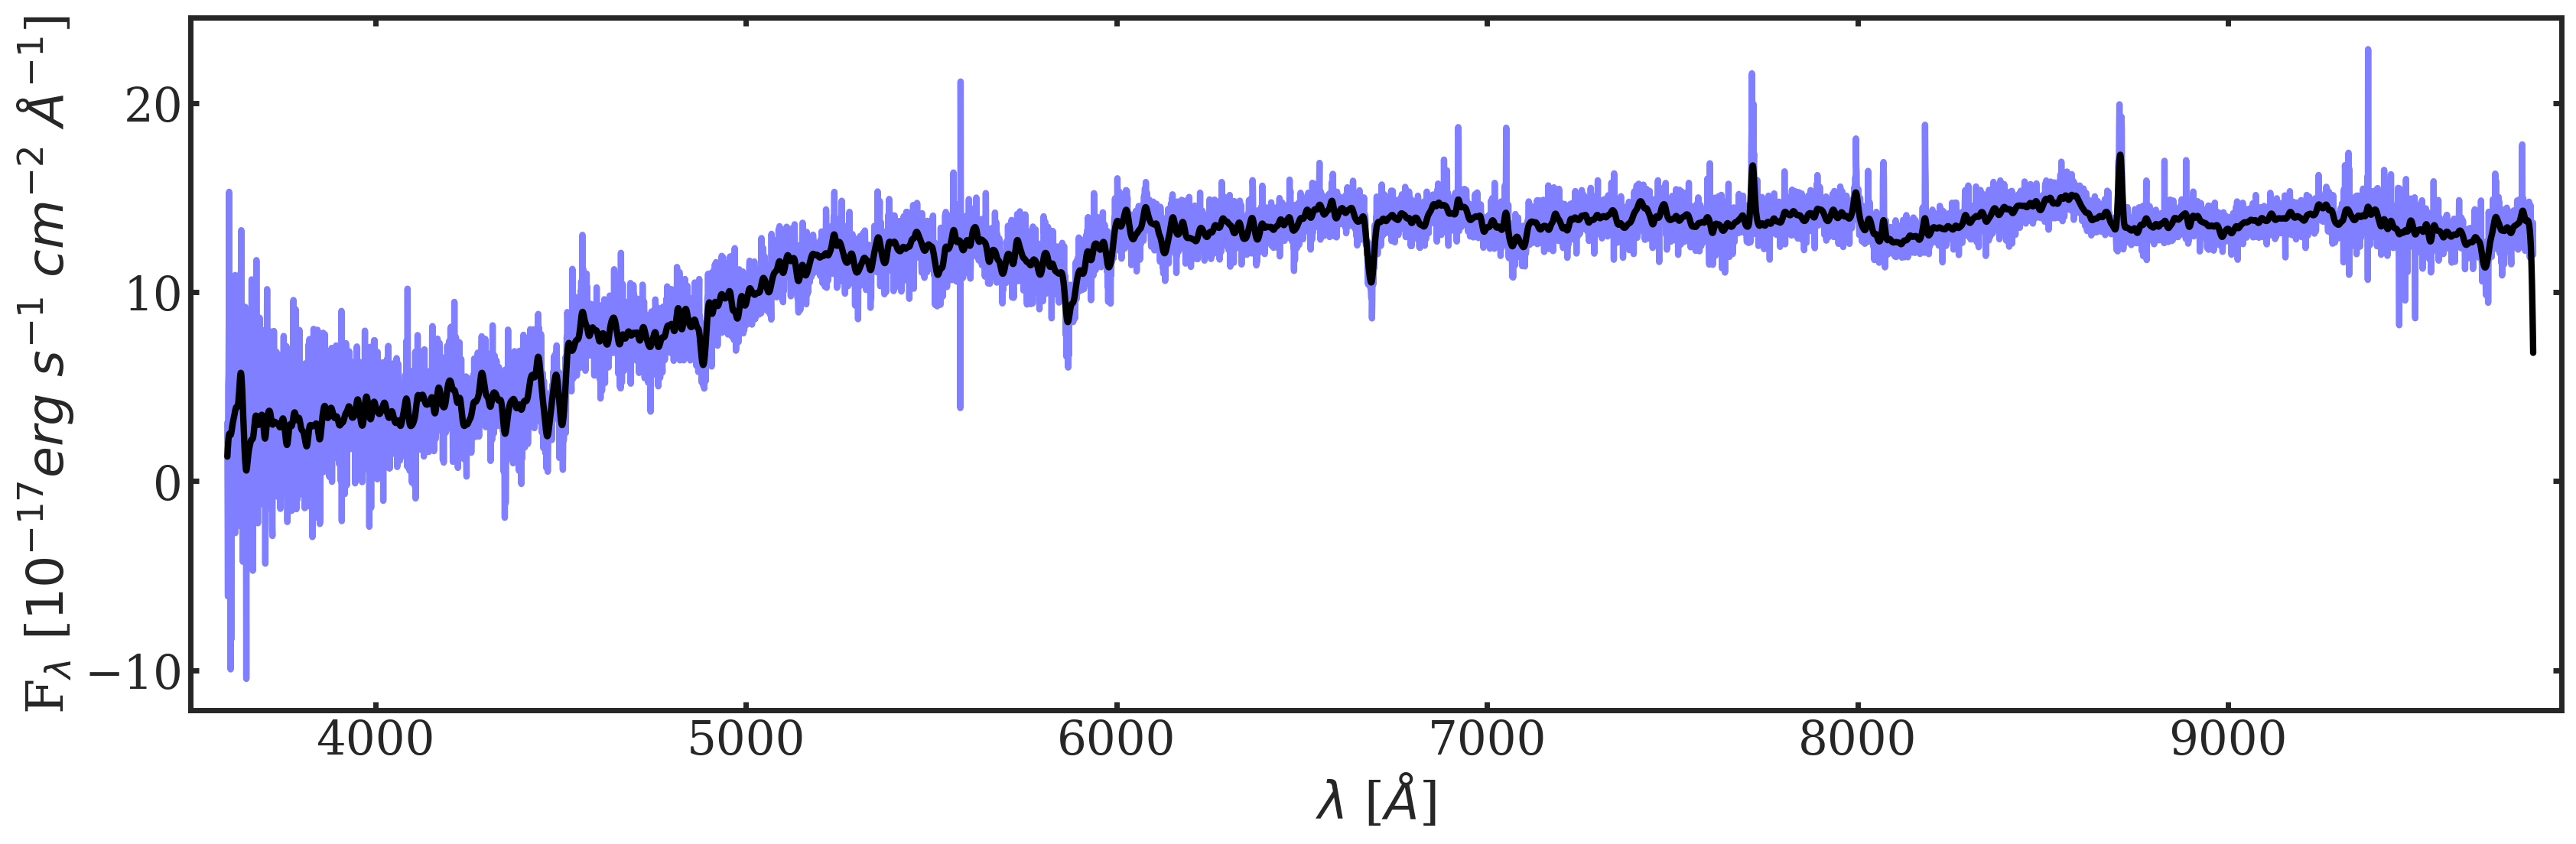

In [9]:
outdir = '/global/cfs/cdirs/desi/users/nrfran/speclens/'

# read in the fastspecfit model
foregroundpath = os.path.join(outdir, 'fastspec-sv3-bright-25964-out.fits')
frontWave, frontFlux, meta = getFastspecModel(foregroundpath)

# read in coadded original spectrum
orig = os.path.join(outdir, 'coadd-sv3-bright-25964-out.fits')
coaddSpec = readCoadd(orig, meta)

# plot the original spectrum
plotDesiSpectra(coaddSpec)

## First Foreground

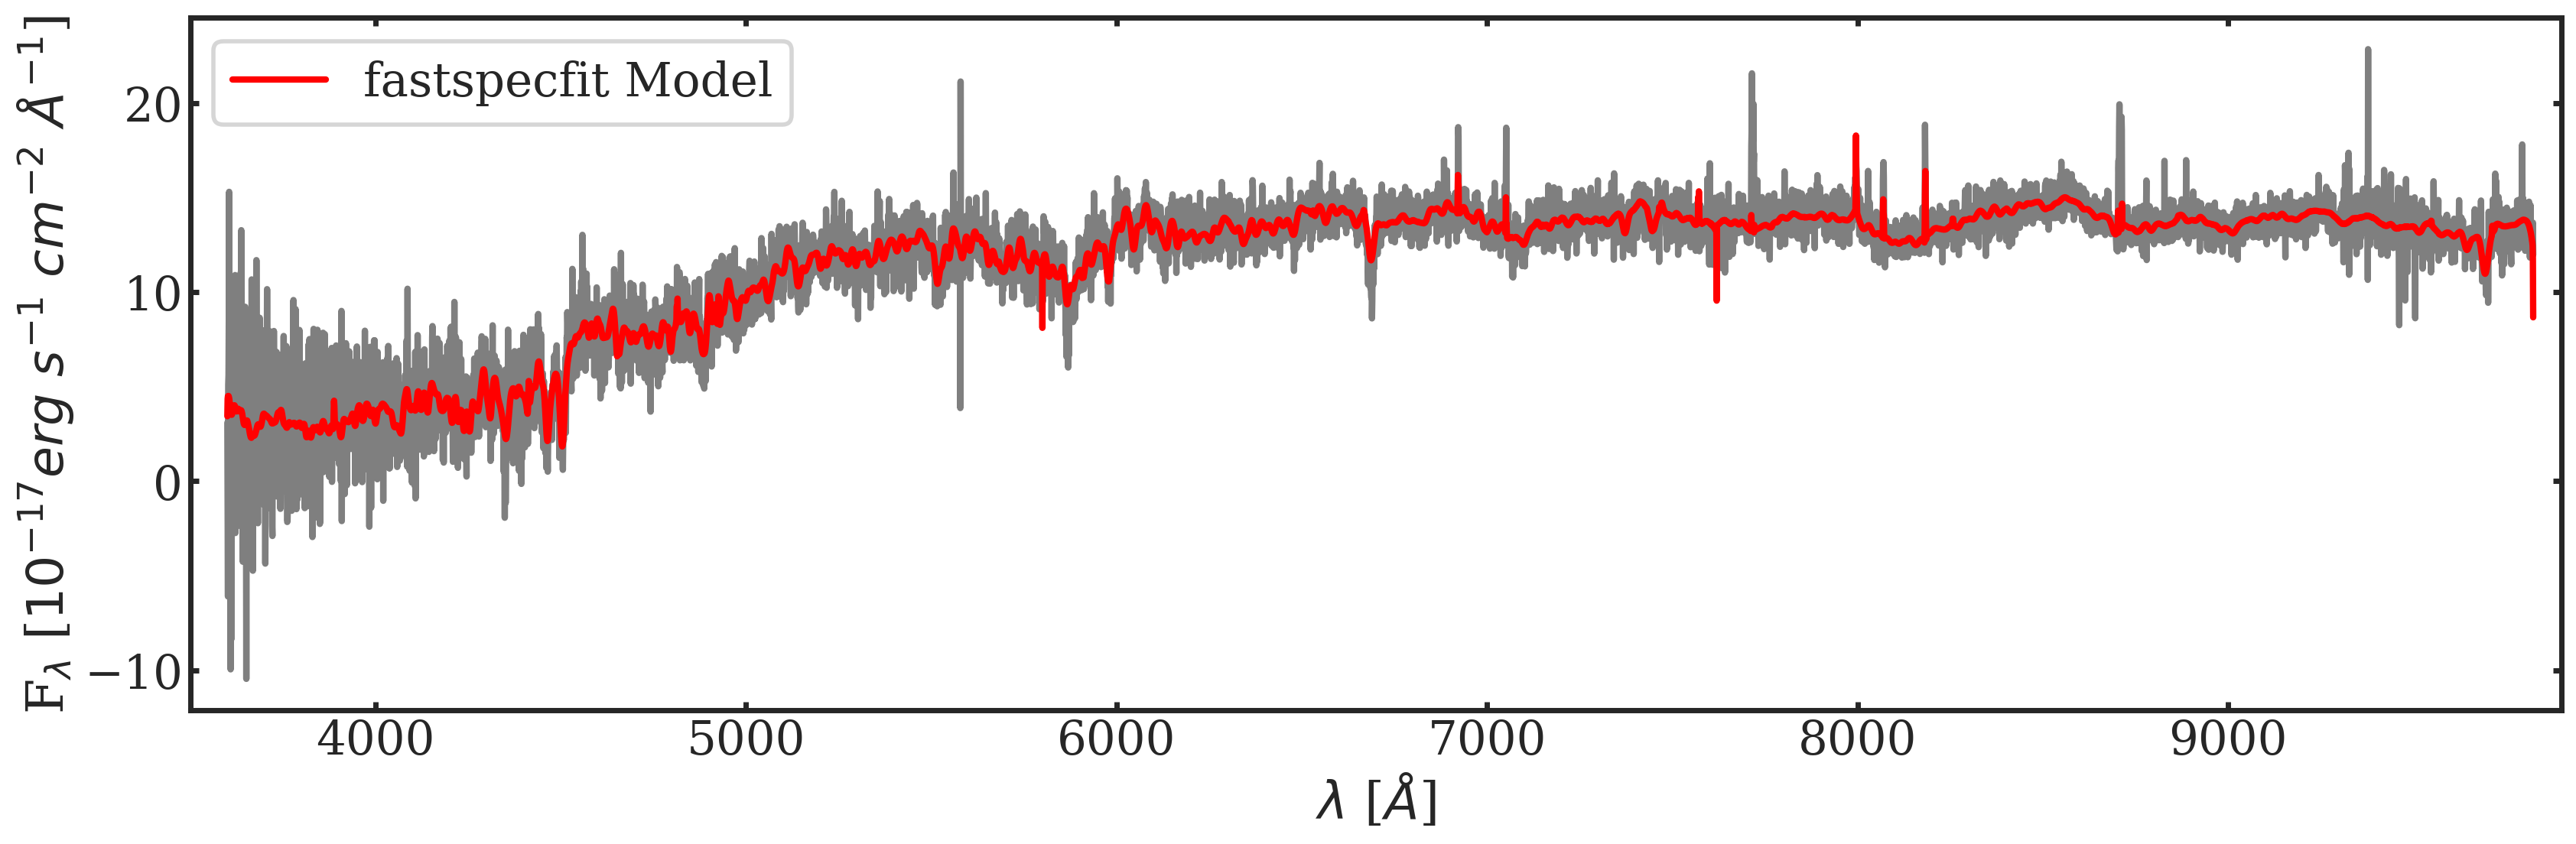

In [10]:
plotFastspecModel(frontWave, frontFlux, coaddSpec)

# Subtract the spectra and plot the background spectrum

In [11]:
sourceSpec, sourceSpecPath = subtract_spectra(coaddSpec, frontFlux, frontWave)

INFO:spectra.py:184:write_spectra: iotime 0.054 sec to write soource-spectra.fits at 2022-12-02T08:26:01.568922


1.1487


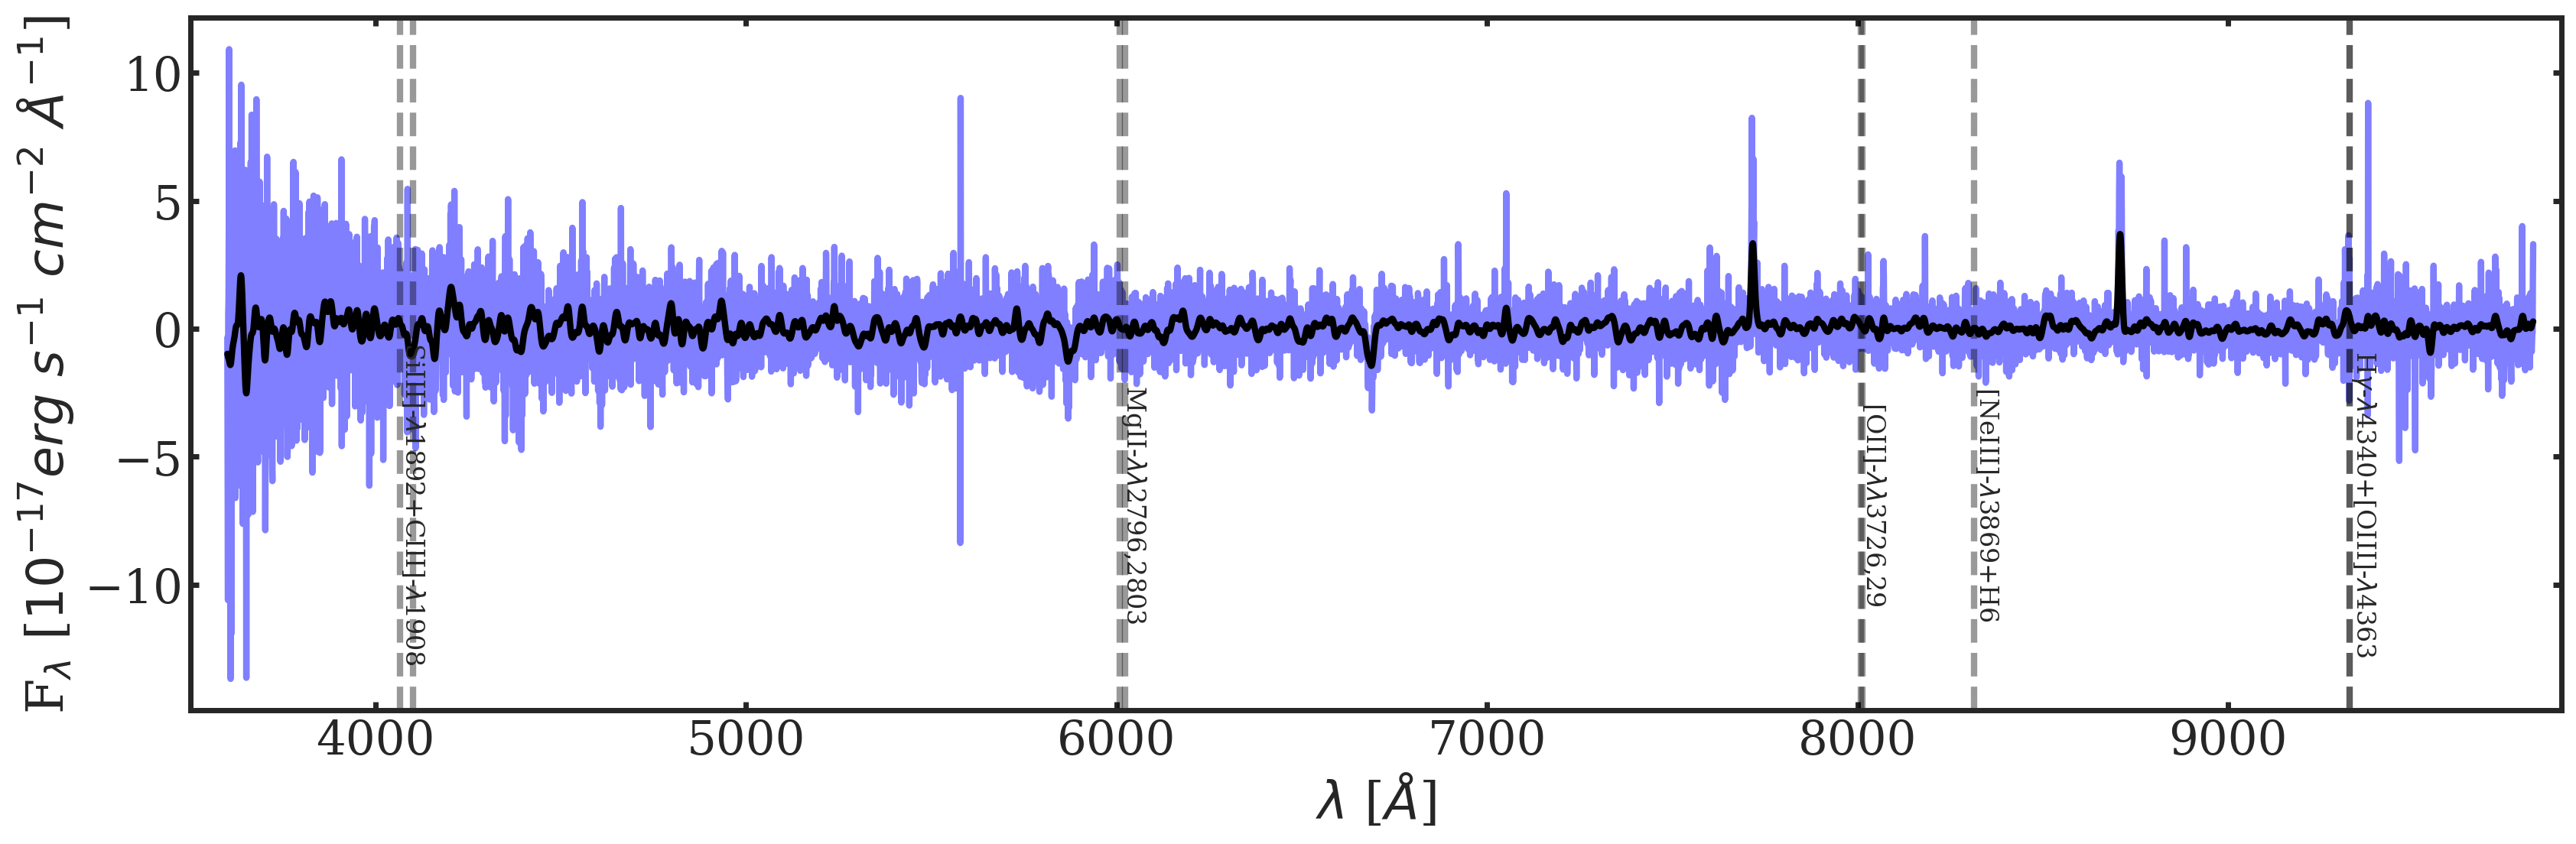

In [12]:
# get accepted redshift for our target

fujiMatches = Table.read('fuji-matches.ecsv', format='ascii.ecsv')
goodMatches = Table.read('z_catalog_sv3_bright_25964.fits')
masterlens = pd.read_csv('masterlens.tsv', sep='\t', skiprows=1)

firstMatch = fujiMatches[fujiMatches['TARGETID'] == goodMatches['TARGETID'].data[0]]
matchName = firstMatch['OBJNAME'].data[0]

goodLens = masterlens[masterlens.iloc[:,0] == matchName]

zSource = float(goodLens[' "z_source"'].values[0].strip())
print(zSource)

plotDesiSpectra(sourceSpec, emline=True, z=zSource)

In [13]:
outfile = os.path.join(outdir, 'rr_output', 'rr-outfile-test1.fits')
details = os.path.join(outdir, 'rr_output', 'rr-details-test1.fits')
zbest = wrap_redrock([outfile], [sourceSpecPath], details)

Overwrite set to False and redrock file exists so skipping...
Writing 1 redshifts to lenssource-zbest.fits


Lens DESI Redshit = 0.13455889935099644
Lens masterlens/literature Redshift = 0.5713
Source masterlens/literature Redshift = 1.1487
Source Redrock Redshift = 0.7389664413165209


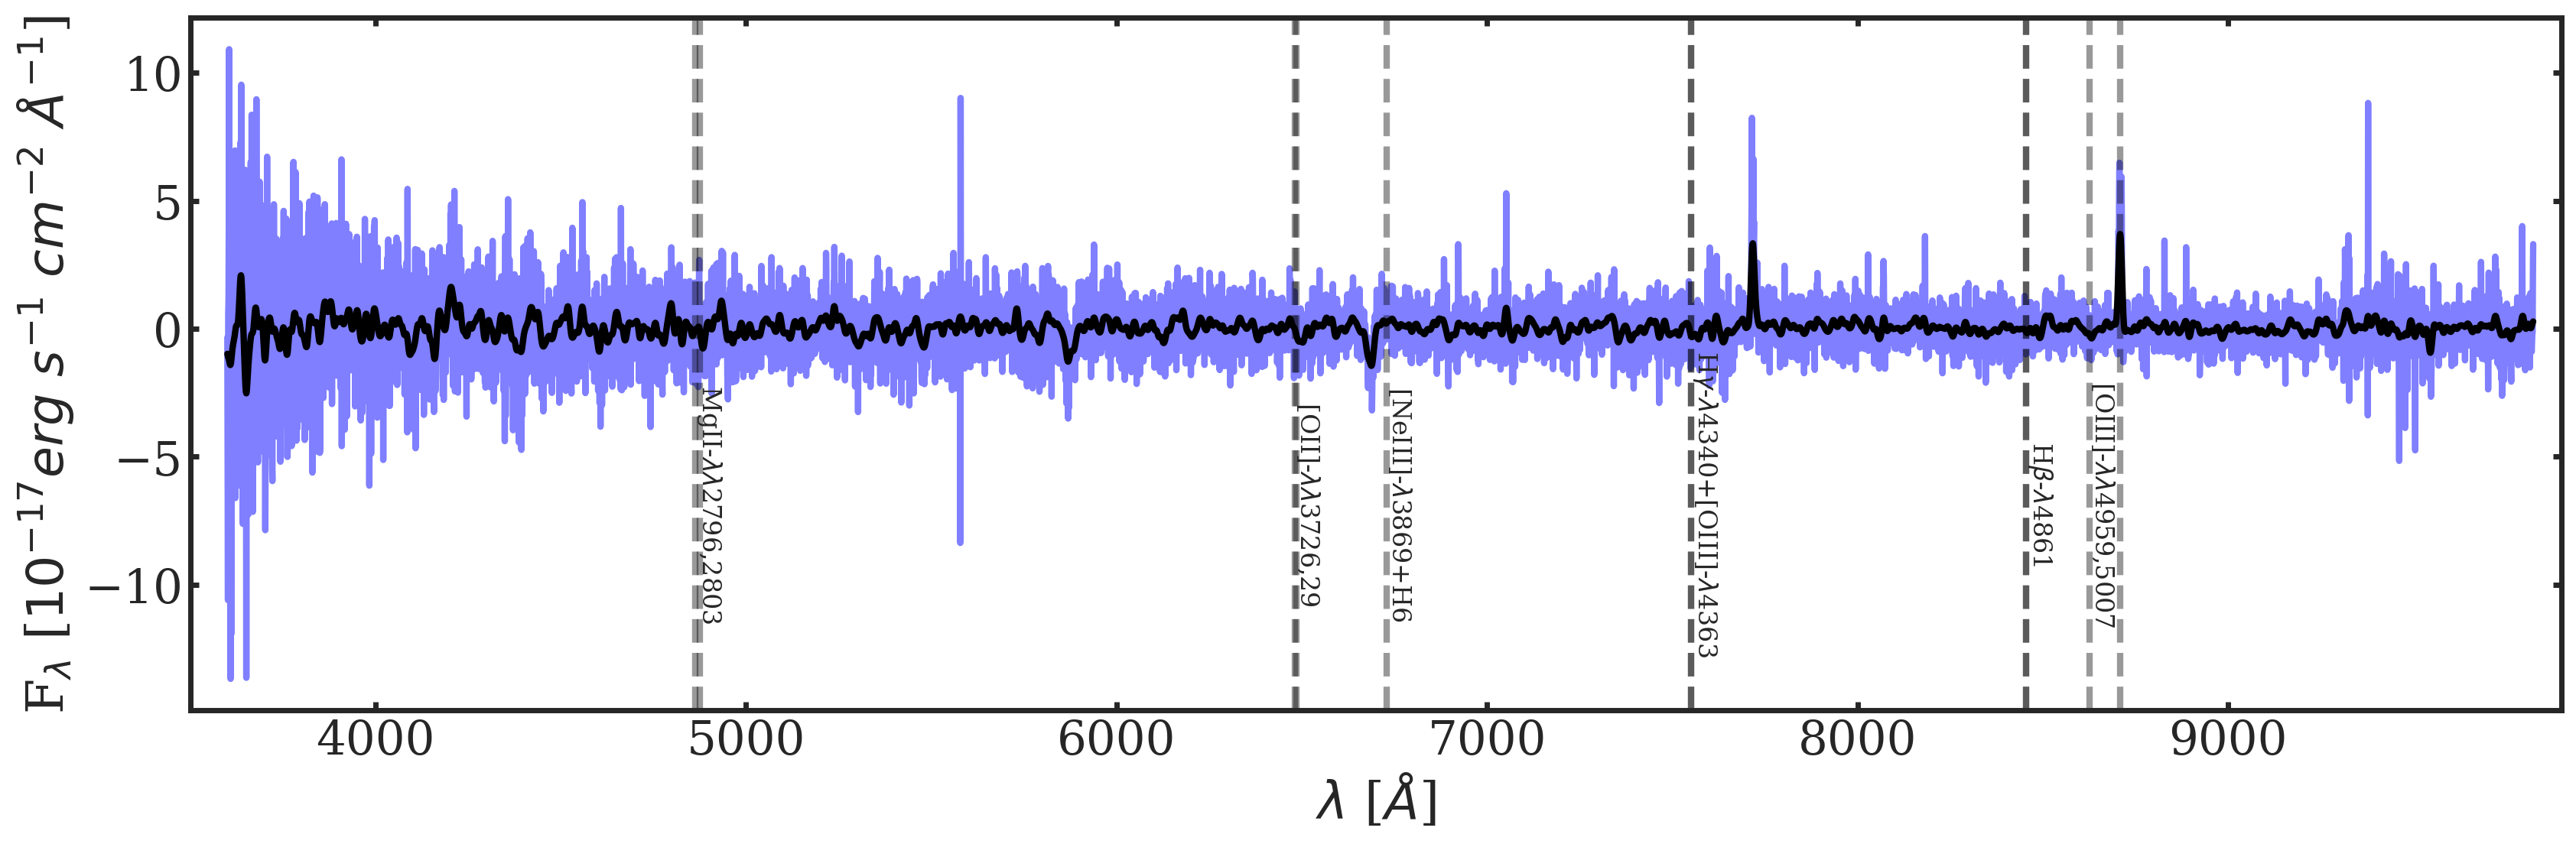

In [14]:
rrOut = Table(fitsio.read(outfile))
plotDesiSpectra(sourceSpec, emline=True, z=rrOut['Z'])

lensZ = firstMatch['Z'][0]
rrZ = rrOut['Z'][0]
masterlensZ = float(goodLens[' "z_lens"'].values[0].strip())

print(f'Lens DESI Redshit = {lensZ}')
print(f'Lens masterlens/literature Redshift = {masterlensZ}')
print(f'Source masterlens/literature Redshift = {zSource}')
print(f'Source Redrock Redshift = {rrZ}')

In [15]:
def rrplot(specfile, rrfile, targetids=None, datatype='desi', allspec=False, templates=None, archetypes=None, use_archetype=False):
    '''
    Function to plot redrock chi2 result and spectrum best fit model
    
    specfile [string] : input spectra or spPlate files
    rrfile [string] : redrock details h5 file from rrdesi/rrboss
    targetids [string] : comma-separated list of target IDs
    datatype [string] : input data type: desi or boss
    allspec [bool] : use individual spectra instead of coadd
    templates [string] : template directory
    archetypes [string] : archetype file or directory
    use_archetype [bool] : Use archetype to compare different best fit
    '''
    
    import redrock
    import redrock.templates
    import redrock.archetypes
    #import redrock.plotspec
    from plotspec import PlotSpec
    
    #- Templates
    templates_path = redrock.templates.find_templates(templates)
    templates = {}
    for el in templates_path:
        t = redrock.templates.Template(filename=el)
        templates[t.full_type] = t

    #- Targetids
    targetids = None
    if targetids is not None:
        targetids = [ int(x) for x in targetids.split(",") ]

    #- Archetypes
    if use_archetype:
        archetypes = redrock.archetypes.All_archetypes(archetypes_dir=archetypes)
    else:
        archetypes = False

    #- Data
    if datatype=='desi':
        from redrock.external import desi
        targets = desi.DistTargetsDESI(specfile, targetids=targetids, coadd=(not allspec))._my_data
    elif datatype=='boss':
        from redrock.external import boss
        targets, targetids = boss.read_spectra(specfile, targetids=targetids, coadd=(not allspec))

    #- Redrock
    zscan, zfit = redrock.results.read_zscan(rrfile)

    #- Plot
    p = PlotSpec(targets, templates, zscan, zfit, chi2range=[9400, 10000], nBestFits=3, archetypes=archetypes)
    

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock-templates/main
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using redshift range 1.4000-6.9930 for rrtemplate-qso-HIZ.fits
DEBUG: Using redshift range 0.0500-1.5983 for rrtemplate-qso-LOZ.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
------------------------------------------

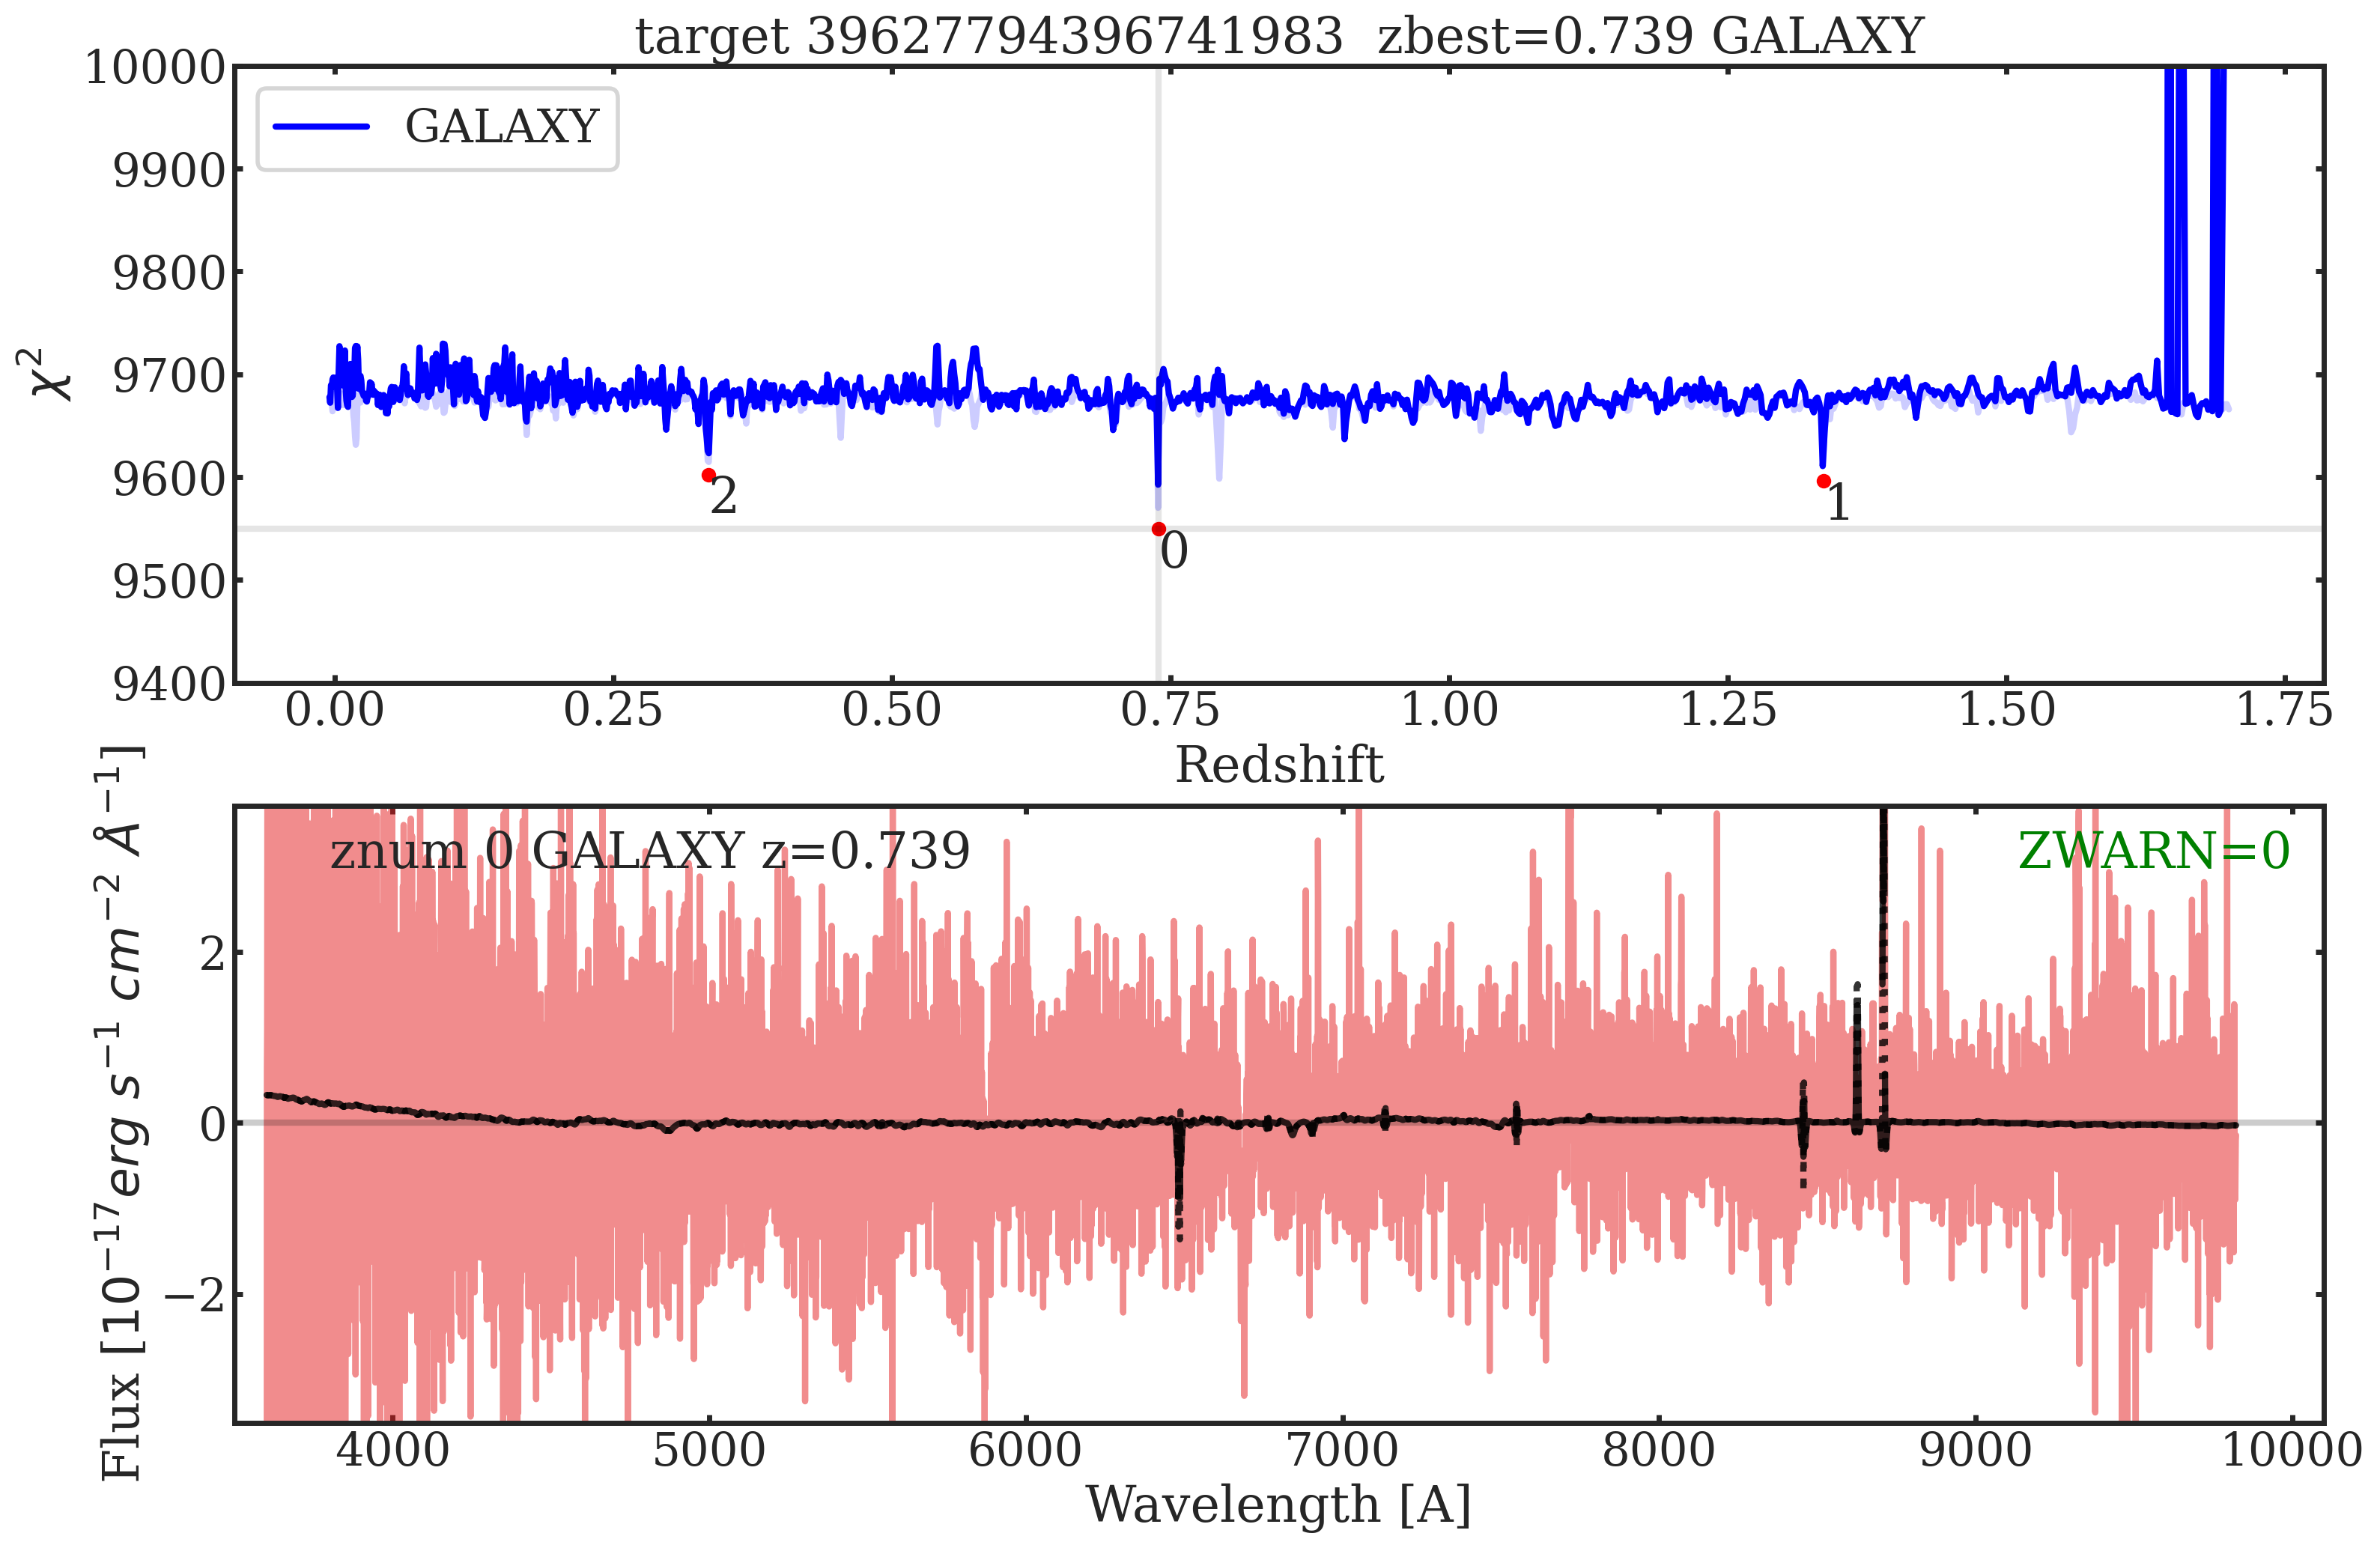

In [16]:
# Create plot of chi2 values

rrplot(sourceSpecPath, details)


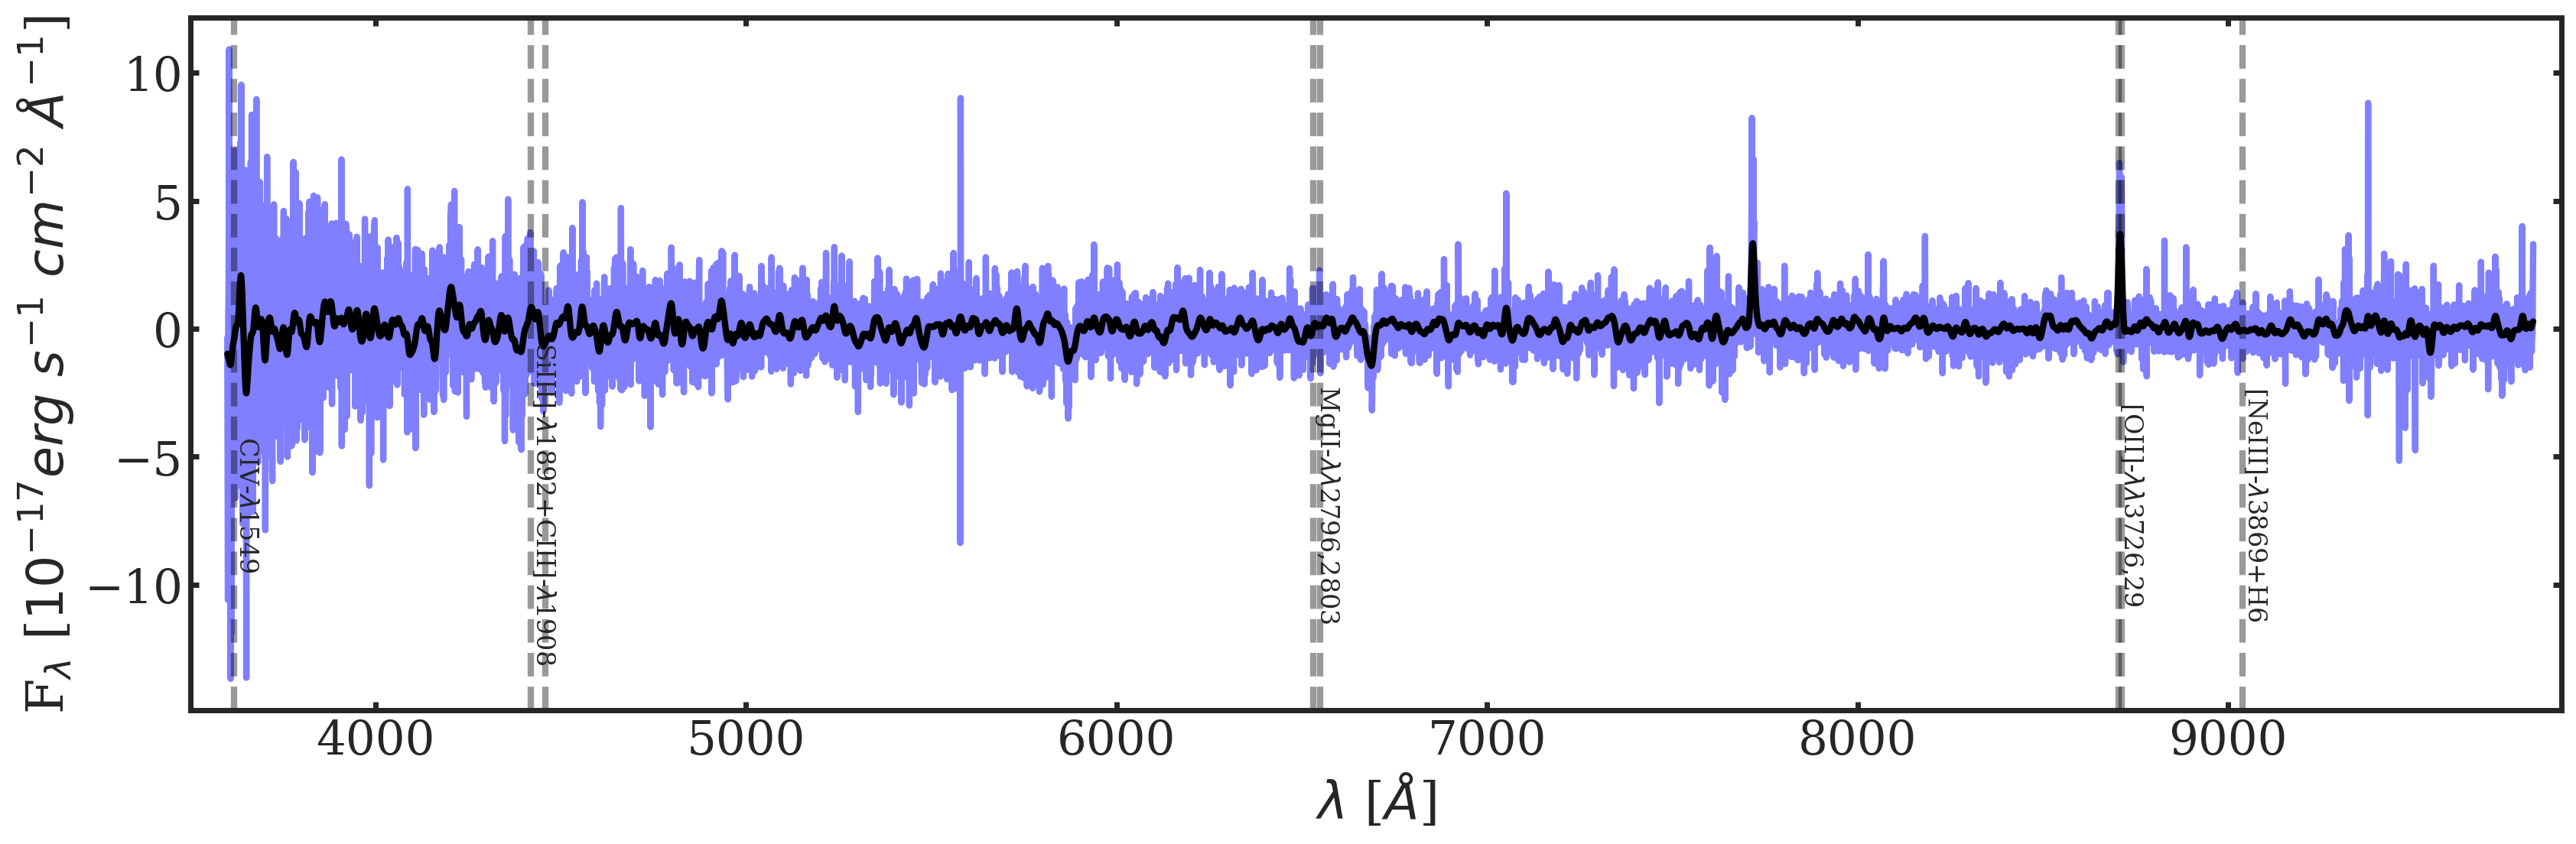

In [17]:
row = 1

rrDetails = Table.read(details)
plotDesiSpectra(sourceSpec, emline=True, z=rrDetails['z'][row])

#rrDetails